<a href="https://colab.research.google.com/github/FunmilolaAdetuwo/Final-Project/blob/main/Advanced_AI_Techniques_for_Predicting_Currency_Exchange_Rates_A_Deep_Learning_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instal the World bank library

!pip install wbdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
bigframes 1.29.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [1]:
# Instal the keras tuner library
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [2]:
# Importing necessary libraries

import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import wbdata as wb
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.layers import GRU, Dropout, Dense
from keras.models import Sequential
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from tensorflow.keras.regularizers import l2

<ipython-input-2-31c1e52c3c7b>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


First, we will be fetching the currency data from the Yahoo Finance. The GBP and the USD will be the currency that will be used for this project The period that will be used for this project will be from 01 January 2004 to 31 December 2023

In [3]:
# Defining the ticker symbol for GBP/USD
tcker_symb = "GBPUSD=X"

# Setting the data range
strt_dt = "2004-01-01"
ed_dt = "2023-12-31"

# Fetching the data
crcy_dt = yf.download(tcker_symb, start=strt_dt, end=ed_dt)

# setting the index to convert the index to a date column
crcy_dt.reset_index(inplace=True)

# Flattening the columns
crcy_dt.columns = ['_'.join(col).strip() if col[1] else col[0] for col in crcy_dt.columns.values]

crcy_dt['Date'] = pd.to_datetime(crcy_dt['Date'])


# Display the data structure after modification
print("Data after flattening columns and setting 'Date':")
print(crcy_dt.head())

[*********************100%***********************]  1 of 1 completed

Data after flattening columns and setting 'Date':
        Date  Adj Close_GBPUSD=X  Close_GBPUSD=X  High_GBPUSD=X  Low_GBPUSD=X  \
0 2004-01-01            1.785204        1.785204       1.788813      1.781705   
1 2004-01-02            1.793690        1.793690       1.795010      1.779201   
2 2004-01-05            1.807207        1.807207       1.810315      1.795107   
3 2004-01-06            1.821295        1.821295       1.827786      1.805510   
4 2004-01-07            1.817785        1.817785       1.825584      1.812711   

   Open_GBPUSD=X  Volume_GBPUSD=X  
0       1.788813                0  
1       1.785587                0  
2       1.795493                0  
3       1.807403                0  
4       1.820897                0  


Now, using the same period, we will fetch the macro economic data from the World bank for the United Kingdom and United States.

The indicators to be used is the GDP and Inflation rate.

In [4]:
# Setting the date range
dt_dte = ("2004", "2023")

# Getting the GDP and Inflation data for US and UK
gdp_dt = wb.get_data("NY.GDP.MKTP.CD", country=['GBR', 'USA'], date=dt_dte)
ifltn_dt = wb.get_data("FP.CPI.TOTL.ZG", country=['GBR', 'USA'], date=dt_dte)

# Converting this into DataFrames
gdp_df = pd.DataFrame(gdp_dt)
ifltn_df = pd.DataFrame(ifltn_dt)

def extract_dict_value(row, key):
    return row[key]['value'] if isinstance(row[key], dict) else row[key]

gdp_df['country'] = gdp_df['country'].apply(extract_dict_value, key='value')
gdp_df['indicator'] = gdp_df['indicator'].apply(extract_dict_value, key='value')

ifltn_df['country'] = ifltn_df['country'].apply(extract_dict_value, key='value')
ifltn_df['indicator'] = ifltn_df['indicator'].apply(extract_dict_value, key='value')

gdp_df['date'] = pd.to_datetime(gdp_df['date'])
ifltn_df['date'] = pd.to_datetime(ifltn_df['date'])

gdp_pt = gdp_df.pivot(index='date', columns='country', values='value').rename(columns=lambda x: f"GDP_{x}")
ifltn_pt = ifltn_df.pivot(index='date', columns='country', values='value').rename(columns=lambda x: f"Inflation_{x}")

# Merging the GDP and Inflation data into a single DataFrame
ecomc_dt = gdp_pt.join(ifltn_pt, how='outer')

# Displaying the data
print(ecomc_dt.head())

country     GDP_United Kingdom  GDP_United States  Inflation_United Kingdom  \
date                                                                          
2004-01-01        2.421525e+12       1.221720e+13                  1.390398   
2005-01-01        2.543180e+12       1.303920e+13                  2.089136   
2006-01-01        2.708442e+12       1.381558e+13                  2.455662   
2007-01-01        3.090510e+12       1.447423e+13                  2.386562   
2008-01-01        2.929412e+12       1.476986e+13                  3.521409   

country     Inflation_United States  
date                                 
2004-01-01                 2.677237  
2005-01-01                 3.392747  
2006-01-01                 3.225944  
2007-01-01                 2.852672  
2008-01-01                 3.839100  


The Currency data and the Macroeconomic data is merged together. The daily exchange rate data of GBP/USD with annual GDP and inflation data for the UK and the US was merged together. In this integration, there is high-frequency daily data, which shows trends in currency exchange rate, with lower-frequency annual data that shows the macro economic data.

The datasets are different in frequency—daily for exchange rates and annually for macro economic indicators. This was aligned by using a forward fill method, which carries forward the last known annual values until new data becomes available. This means every daily exchange rate from January 1, 2004, to December 29, 2023, is associated with the latest annual macro economic data.

In [5]:
crcy_dt['Date'] = crcy_dt['Date'].dt.tz_localize(None)
ecomc_dt.index = ecomc_dt.index.tz_localize(None)

# Merging the daily currency data with the economic data using forward fill to handle the missing daily values
cmbd_dt = pd.merge(crcy_dt, ecomc_dt, left_on='Date', right_index=True, how='left')
cmbd_dt.fillna(method='ffill', inplace=True)

# Displaying the combined data
print(cmbd_dt.head())

        Date  Adj Close_GBPUSD=X  Close_GBPUSD=X  High_GBPUSD=X  Low_GBPUSD=X  \
0 2004-01-01            1.785204        1.785204       1.788813      1.781705   
1 2004-01-02            1.793690        1.793690       1.795010      1.779201   
2 2004-01-05            1.807207        1.807207       1.810315      1.795107   
3 2004-01-06            1.821295        1.821295       1.827786      1.805510   
4 2004-01-07            1.817785        1.817785       1.825584      1.812711   

   Open_GBPUSD=X  Volume_GBPUSD=X  GDP_United Kingdom  GDP_United States  \
0       1.788813                0        2.421525e+12       1.221720e+13   
1       1.785587                0        2.421525e+12       1.221720e+13   
2       1.795493                0        2.421525e+12       1.221720e+13   
3       1.807403                0        2.421525e+12       1.221720e+13   
4       1.820897                0        2.421525e+12       1.221720e+13   

   Inflation_United Kingdom  Inflation_United States  
0

<ipython-input-5-c6f190ef9204>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cmbd_dt.fillna(method='ffill', inplace=True)


**Exploratory Data Analysis (EDA)**

The EDA shows that the dataset contains 5,200 entries. The dataset does not contain any null value- there is no missing value as we have addressed it earlier.The data types shows that the date column uses datetime64[ns] format while the numerical data is stored as a float which is suitable for a time series analysis.

The GBP/USD exchange rate trends graph shows the change in the exchange rate over the years, it captures significant movement in the currency. The ups and downs highlight periods of volatility, which may correspond to macro economic events affecting the currencies.

The GDP trends graphs shows in a step-chart format, the GDP for each country showing an incremental change on a year by year basis. The UK's GDP is consistently lower than that of the US, showing the larger scale of the US economy compared to the UK. The graph shows economic growth periods and potential declines.

The Inflation rate trend graph shows how inflation has varied over the years in both UK and US. The graph shows periods of higher inflation, which often correlates with economic policies.

The distribution of GBP/USD exchange rates graph shows that the majority of exchange values is centred around the 1.3 mark, indicating a left-skewed distribution, suggesting that the British pound normally traded at this rate in relation to the US dollar. The spread towards lower values around 1.1 indicates times of relative weakness in the pound, while peaks around 1.5 indicate sporadic periods of higher exchange rates.

The GDP distributions for the US and the UK graph shows that the US GDP exhibits a greater variance over higher values, with peaks around 2 trillion USD, the UK's GDP distribution exhibits tight clustering around lower values (between 0.3 and 0.5 trillion). With the US economy continuously functioning at a larger scale than the UK across the period, this discrepancy emphasises an economic size gap.

The GBP/USD exchange rate box plot indicates that the median value is approximately 1.5, with most values falling between 1.4 and 1.6. The "whiskers" extend to just above 2.0 and below 1.2, showing the full data range without extreme outliers.

In [6]:
# Displaying the descriptive statistics of the combined dataset
print(cmbd_dt.describe())

# checkingto see non-null and data types
print(cmbd_dt.info())

                                Date  Adj Close_GBPUSD=X  Close_GBPUSD=X  \
count                           5200         5200.000000     5200.000000   
mean   2014-01-04 07:01:45.230769152            1.538863        1.538863   
min              2004-01-01 00:00:00            1.072754        1.072754   
25%              2009-01-11 06:00:00            1.314488        1.314488   
50%              2014-01-07 12:00:00            1.541390        1.541390   
75%              2019-01-03 06:00:00            1.682992        1.682992   
max              2023-12-29 00:00:00            2.108192        2.108192   
std                              NaN            0.239130        0.239130   

       High_GBPUSD=X  Low_GBPUSD=X  Open_GBPUSD=X  Volume_GBPUSD=X  \
count    5200.000000   5200.000000    5200.000000           5200.0   
mean        1.544632      1.532616       1.538840              0.0   
min         1.083541      0.637389       1.072846              0.0   
25%         1.319575      1.309925 

In [7]:
# Ensuring that the date column is in datetime format
cmbd_dt['Date'] = pd.to_datetime(cmbd_dt['Date'], errors='coerce')

cmbd_dt.set_index('Date', inplace=True)

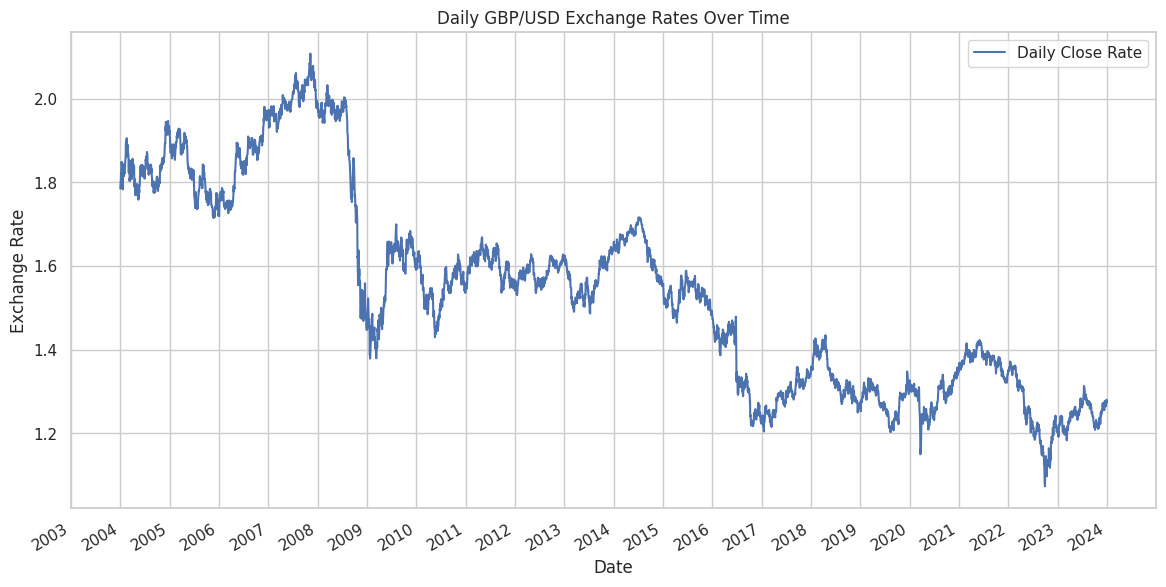

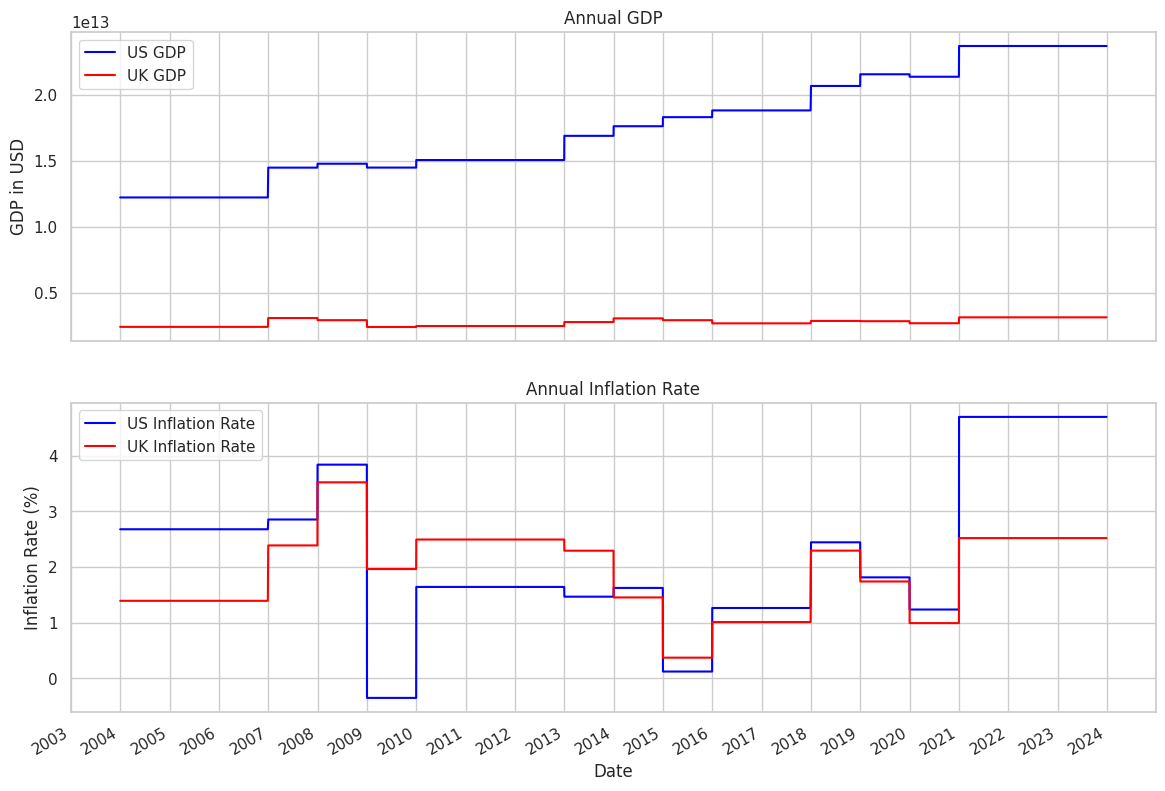

In [8]:
# Visualizing the dataset trends

# Setting the style
sns.set(style="whitegrid")

# Plotting the currency exchange rates
plt.figure(figsize=(14, 7))
plt.plot(cmbd_dt.index, cmbd_dt['Close_GBPUSD=X'], label='Daily Close Rate')
plt.title('Daily GBP/USD Exchange Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()

# Setting the date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.show()


plt.show()

# Plotting GDP and Inflation trends
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax[0].plot(cmbd_dt.index, cmbd_dt['GDP_United States'], label='US GDP', color='blue')
ax[0].plot(cmbd_dt.index, cmbd_dt['GDP_United Kingdom'], label='UK GDP', color='red')
ax[0].set_title('Annual GDP')
ax[0].set_ylabel('GDP in USD')
ax[0].legend()

ax[1].plot(cmbd_dt.index, cmbd_dt['Inflation_United States'], label='US Inflation Rate', color='blue')
ax[1].plot(cmbd_dt.index, cmbd_dt['Inflation_United Kingdom'], label='UK Inflation Rate', color='red')
ax[1].set_title('Annual Inflation Rate')
ax[1].set_ylabel('Inflation Rate (%)')
ax[1].set_xlabel('Date')
ax[1].legend()

# Setting the date format on x-axis for the subplot
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

plt.show()


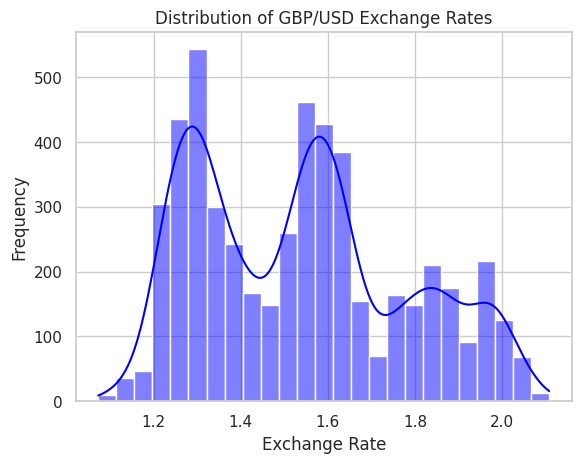

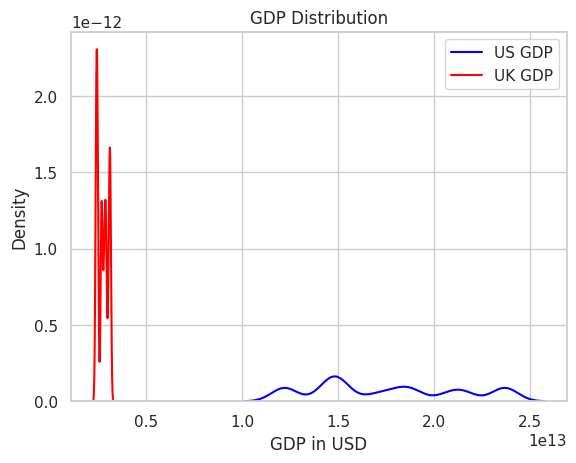

In [9]:
# Analyzing the distribution of the key variables

# plotting histogram for the exchange rates
sns.histplot(cmbd_dt['Close_GBPUSD=X'], kde=True, color='blue')
plt.title('Distribution of GBP/USD Exchange Rates')
plt.xlabel('Exchange Rate')
plt.ylabel('Frequency')
plt.show()

# Kernel density estimate for the GDP data
sns.kdeplot(cmbd_dt['GDP_United States'], label='US GDP', color='blue')
sns.kdeplot(cmbd_dt['GDP_United Kingdom'], label='UK GDP', color='red')
plt.title('GDP Distribution')
plt.xlabel('GDP in USD')
plt.ylabel('Density')
plt.legend()
plt.show()

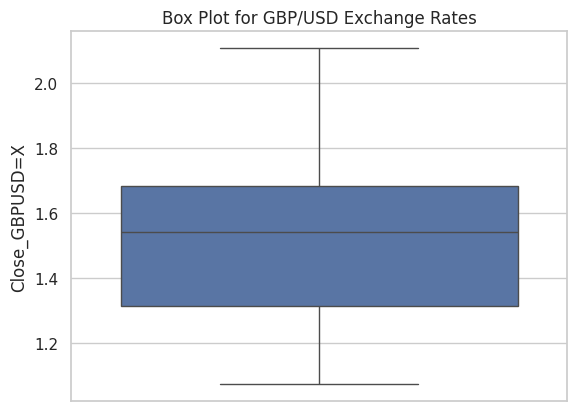

In [10]:
# checking for any outliers or anomalies
sns.boxplot(data=cmbd_dt['Close_GBPUSD=X'])
plt.title('Box Plot for GBP/USD Exchange Rates')
plt.show()


**Feature Engineering**

Feature engineering process was done to improve the dataset by adding new metrics that provide more in-depth understanding of the fluctuations of the GBP/USD exchange rate as well as the US and UK economies. To gain a better understanding of long-term trends, we first computed Moving Averages (MA_7, MA_30, and MA_90), which smooth daily flunctuation by showing average rates over various periods (7, 30, and 90 days). By computing the annual growth rate based on yearly variations, GDP growth for the US and the UK was calculated. This ensures that we examine how changes in economic performance affect exchange rates, which is essential for comprehending long-term movement in currency values.The inflation differential, between the US and the UK, was computed to analyse changes in relative purchasing power, which is a major factor influencing exchange rate fluctuations.A 30-day volatility feature that captures exchange rate volatility over the previous 30 days was calculated in order to quantify market uncertainty.Lastly, the momentum indicator Relative Strength Index (RSI_14) provides a foundation for spotting possible reversals in the direction of the currency by indicating either overbought or oversold levels.

In [11]:
# The first thing is to copy the merged data and bring the date back as a column
ftrs_dt = cmbd_dt.reset_index().copy()

In [12]:
# Moving Averages for Exchange Rate
# A 7-day, 30-day, and 90-day moving averages of the GBP/USD exchange rate will be created
ftrs_dt['MA_7'] = ftrs_dt['Close_GBPUSD=X'].rolling(window=7).mean()
ftrs_dt['MA_30'] = ftrs_dt['Close_GBPUSD=X'].rolling(window=30).mean()
ftrs_dt['MA_90'] = ftrs_dt['Close_GBPUSD=X'].rolling(window=90).mean()

In [13]:
# GDP Growth Rate
# Calculating the yearly GDP growth rate for UK & US
ftrs_dt['Year'] = ftrs_dt['Date'].dt.year
ann_gdp = ftrs_dt.groupby('Year')[['GDP_United Kingdom', 'GDP_United States']].last()
ann_gdp_growth_uk= ann_gdp['GDP_United Kingdom'].pct_change() * 100
ann_gdp_growth_us= ann_gdp['GDP_United States'].pct_change() * 100


ann_gdp_gwth = pd.DataFrame({
    'GDP_Growth_UK': ann_gdp_growth_uk,
    'GDP_Growth_US': ann_gdp_growth_us
})

ann_gdp_gwth['GDP_Growth_UK'] = ann_gdp_gwth['GDP_Growth_UK'].fillna(ann_gdp_gwth['GDP_Growth_UK'].mean())
ann_gdp_gwth['GDP_Growth_US'] = ann_gdp_gwth['GDP_Growth_US'].fillna(ann_gdp_gwth['GDP_Growth_US'].mean())

# Mapping these growth rates for each year
ftrs_dt['GDP_Growth_UK'] = ftrs_dt['Year'].map(ann_gdp_gwth['GDP_Growth_UK'])
ftrs_dt['GDP_Growth_US'] = ftrs_dt['Year'].map(ann_gdp_gwth['GDP_Growth_US'])

ftrs_dt.drop(columns=['Year'], inplace=True)

In [14]:
# Inflation Differential
# Calculating difference in inflation rates between US & UK
ftrs_dt['Inflation_Diff'] = ftrs_dt['Inflation_United States'] - ftrs_dt['Inflation_United Kingdom']

In [15]:
# Volatility(Standard Deviation)
# Calculating the rolling 30-day standard deviation of the GBP/USD exchange rate
ftrs_dt['Volatility_30'] = ftrs_dt['Close_GBPUSD=X'].rolling(window=30).std()

In [16]:
# Relative Strength Index (RSI)
# RSI calculation using a 14-day period
dlt = ftrs_dt['Close_GBPUSD=X'].diff(1)
gn = dlt.where(dlt > 0, 0)
ls = -dlt.where(dlt < 0, 0)
av_gn = gn.rolling(window=14).mean()
av_ls = ls.rolling(window=14).mean()
rs = av_gn / av_ls
ftrs_dt['RSI_14'] = 100 - (100 / (1 + rs))

In [17]:
# Backfilling the initial rows with NaN values from the calculations
ftrs_dt[['MA_7', 'MA_30', 'MA_90', 'Volatility_30', 'RSI_14']] = ftrs_dt[['MA_7', 'MA_30', 'MA_90', 'Volatility_30', 'RSI_14']].bfill()

# Displaying the new feature
print("Feature engineered dataset:")
print(ftrs_dt[['Date', 'Open_GBPUSD=X', 'Close_GBPUSD=X', 'MA_7', 'MA_30', 'MA_90',
                   'GDP_United Kingdom', 'GDP_United States', 'GDP_Growth_UK',
                   'GDP_Growth_US', 'Inflation_United Kingdom', 'Inflation_United States',
                   'Inflation_Diff', 'Volatility_30', 'RSI_14']].head())

Feature engineered dataset:
        Date  Open_GBPUSD=X  Close_GBPUSD=X      MA_7     MA_30     MA_90  \
0 2004-01-01       1.788813        1.785204  1.815308  1.828599  1.828355   
1 2004-01-02       1.785587        1.793690  1.815308  1.828599  1.828355   
2 2004-01-05       1.795493        1.807207  1.815308  1.828599  1.828355   
3 2004-01-06       1.807403        1.821295  1.815308  1.828599  1.828355   
4 2004-01-07       1.820897        1.817785  1.815308  1.828599  1.828355   

   GDP_United Kingdom  GDP_United States  GDP_Growth_UK  GDP_Growth_US  \
0        2.421525e+12       1.221720e+13       1.814889       3.674278   
1        2.421525e+12       1.221720e+13       1.814889       3.674278   
2        2.421525e+12       1.221720e+13       1.814889       3.674278   
3        2.421525e+12       1.221720e+13       1.814889       3.674278   
4        2.421525e+12       1.221720e+13       1.814889       3.674278   

   Inflation_United Kingdom  Inflation_United States  Inflation_

**Data Preprocessing**

In [18]:
# Copying the feature-engineered dataset for preprocessing
prpsed_dt = ftrs_dt.copy()

In [19]:
# Selecting the features for scaling, excluding 'Date' and 'Close_GBPUSD=X' as it is the target variable
ftrs_to_scl = [
    'Open_GBPUSD=X', 'MA_7', 'MA_30', 'MA_90', 'GDP_Growth_UK',
    'GDP_Growth_US', 'Inflation_Diff', 'Volatility_30', 'RSI_14',
    'GDP_United Kingdom', 'GDP_United States', 'Inflation_United Kingdom', 'Inflation_United States'
]


In [20]:
# Initialize the scaler
scaler = StandardScaler()

In [21]:
# Apply the scaler to the selected features
prpsed_dt[ftrs_to_scl] = scaler.fit_transform(prpsed_dt[ftrs_to_scl])

In [22]:
# Displaying the dataset after scaling
print("Dataset after scaling:")
print(prpsed_dt[ftrs_to_scl].head())

Dataset after scaling:
   Open_GBPUSD=X      MA_7    MA_30     MA_90  GDP_Growth_UK  GDP_Growth_US  \
0       1.045527  1.155719  1.20896  1.203643       0.001344       0.001043   
1       1.032034  1.155719  1.20896  1.203643       0.001344       0.001043   
2       1.073469  1.155719  1.20896  1.203643       0.001344       0.001043   
3       1.123283  1.155719  1.20896  1.203643       0.001344       0.001043   
4       1.179721  1.155719  1.20896  1.203643       0.001344       0.001043   

   Inflation_Diff  Volatility_30    RSI_14  GDP_United Kingdom  \
0        0.848069        0.54961  0.579006           -1.259127   
1        0.848069        0.54961  0.579006           -1.259127   
2        0.848069        0.54961  0.579006           -1.259127   
3        0.848069        0.54961  0.579006           -1.259127   
4        0.848069        0.54961  0.579006           -1.259127   

   GDP_United States  Inflation_United Kingdom  Inflation_United States  
0          -1.400921           

In [23]:
# Defining the features (X) and target (y)
X = prpsed_dt[ftrs_to_scl]
y = prpsed_dt['Close_GBPUSD=X']

# Splitting the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Displaying the first few rows of the training data
print("Sample of preprocessed training data:")
print(X_train.head())
print(y_train.head())

Training set size: (4160, 13)
Test set size: (1040, 13)
Sample of preprocessed training data:
   Open_GBPUSD=X      MA_7    MA_30     MA_90  GDP_Growth_UK  GDP_Growth_US  \
0       1.045527  1.155719  1.20896  1.203643       0.001344       0.001043   
1       1.032034  1.155719  1.20896  1.203643       0.001344       0.001043   
2       1.073469  1.155719  1.20896  1.203643       0.001344       0.001043   
3       1.123283  1.155719  1.20896  1.203643       0.001344       0.001043   
4       1.179721  1.155719  1.20896  1.203643       0.001344       0.001043   

   Inflation_Diff  Volatility_30    RSI_14  GDP_United Kingdom  \
0        0.848069        0.54961  0.579006           -1.259127   
1        0.848069        0.54961  0.579006           -1.259127   
2        0.848069        0.54961  0.579006           -1.259127   
3        0.848069        0.54961  0.579006           -1.259127   
4        0.848069        0.54961  0.579006           -1.259127   

   GDP_United States  Inflation_Un